In [9]:
# Cell 0: (Optional) Install fastparquet if you haven’t already
# ------------------------------------------------------------
# %pip install fastparquet

# Cell 1: Load the first 50 000 rows and filter to one device
# -----------------------------------------------------------
from fastparquet import ParquetFile
import pandas as pd

pf      = ParquetFile("training_set/20230327.parquet")
# head() expects nrows=…, then you can pass columns=…
df_head = pf.head(nrows=50000, columns=["deviceid","date","time","lat","lon"])

# Pick the device with the most pings in this chunk
top_dev = df_head['deviceid'].value_counts().idxmax()
df_user = df_head[df_head['deviceid'] == top_dev].reset_index(drop=True)

print(f"Analyzing device: {top_dev} — {len(df_user)} pings")
print(df_user)


Analyzing device: 136b30f450ef55cf22afcc5e6213c5f7f664766324c1057fa6edef424409b6a4 — 18 pings
                                             deviceid        date      time  \
0   136b30f450ef55cf22afcc5e6213c5f7f664766324c105...  27.03.2023  20:00:04   
1   136b30f450ef55cf22afcc5e6213c5f7f664766324c105...  27.03.2023  20:00:07   
2   136b30f450ef55cf22afcc5e6213c5f7f664766324c105...  27.03.2023  20:00:19   
3   136b30f450ef55cf22afcc5e6213c5f7f664766324c105...  27.03.2023  20:00:22   
4   136b30f450ef55cf22afcc5e6213c5f7f664766324c105...  27.03.2023  20:00:29   
5   136b30f450ef55cf22afcc5e6213c5f7f664766324c105...  27.03.2023  18:00:06   
6   136b30f450ef55cf22afcc5e6213c5f7f664766324c105...  27.03.2023  20:00:33   
7   136b30f450ef55cf22afcc5e6213c5f7f664766324c105...  27.03.2023  18:00:10   
8   136b30f450ef55cf22afcc5e6213c5f7f664766324c105...  27.03.2023  18:00:02   
9   136b30f450ef55cf22afcc5e6213c5f7f664766324c105...  27.03.2023  18:00:13   
10  136b30f450ef55cf22afcc5e6213c5f7f

In [4]:
# Cell 2: Quick overview of df_user
# ---------------------------------
print("Shape:", df_user.shape)
print(df_user.info())
print("Null counts:\n", df_user.isna().sum())

Shape: (18, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   deviceid  18 non-null     category
 1   date      18 non-null     category
 2   time      18 non-null     category
 3   lat       18 non-null     float32 
 4   lon       18 non-null     float32 
dtypes: category(3), float32(2)
memory usage: 22.5 MB
None
Null counts:
 deviceid    0
date        0
time        0
lat         0
lon         0
dtype: int64


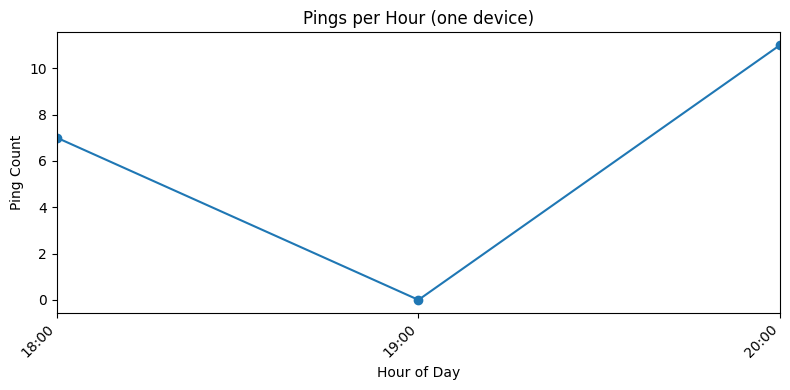

In [10]:
# Cell 3 (cleaned-up): Ping Frequency Over Time with only actual hours shown
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Rebuild datetime index
df_user['datetime'] = pd.to_datetime(
    df_user['date'].astype(str) + " " + df_user['time'].astype(str),
    format="%d.%m.%Y %H:%M:%S"
)
df_user.set_index("datetime", inplace=True)

# Resample to hourly counts
hourly_counts = df_user.resample('h').size()   # lowercase 'h' to avoid the FutureWarning

# Plot
fig, ax = plt.subplots(figsize=(8,4))
hourly_counts.plot(ax=ax, marker='o', linestyle='-')
ax.set_title("Pings per Hour (one device)")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Ping Count")

# Only tick the hours where you actually have data
ticks = hourly_counts.index
ax.set_xticks(ticks)
ax.set_xticklabels([t.strftime('%H:%M') for t in ticks], rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [ ]:
# Cell 4 (with popups): Spatial distribution map with Folium
import folium

center = [df_user['lat'].median(), df_user['lon'].median()]
m1     = folium.Map(location=center, zoom_start=12, control_scale=True)

for _, row in df_user.iterrows():
    # build a little HTML snippet to show on click
    popup_html = (
        f"<b>Datetime:</b> {row.name.strftime('%Y-%m-%d %H:%M:%S')}<br>"
        f"<b>Lat:</b> {row['lat']:.6f}<br>"
        f"<b>Lon:</b> {row['lon']:.6f}"
    )
    folium.CircleMarker(
        location=(row['lat'], row['lon']),
        radius=5,
        color="blue",
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(popup_html, max_width=200),
        tooltip="Click for details"
    ).add_to(m1)

m1.save("user_spatial_map_with_popups.html")
print("Saved user_spatial_map_with_popups.html")


Saved user_spatial_map.html — plotted 18 points


In [ ]:
# Cell 5: Speed distribution histogram
# ------------------------------------
import numpy as np

df_user.sort_index(inplace=True)

lats       = np.radians(df_user['lat'].values)
lons       = np.radians(df_user['lon'].values)
dlat       = lats[1:] - lats[:-1]
dlon       = lons[1:] - lons[:-1]
a          = np.sin(dlat/2)**2 + np.cos(lats[:-1]) * np.cos(lats[1:]) * np.sin(dlon/2)**2
distances  = 2 * 6371000 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
time_deltas= df_user.index.to_series().diff().dt.total_seconds().values[1:]

valid      = time_deltas > 0
speeds     = distances[valid] / time_deltas[valid]
speeds     = speeds[np.isfinite(speeds) & (speeds >= 0)]

plt.figure()
plt.hist(speeds, bins=50)
plt.title("Instantaneous Speeds (m/s) — one device")
plt.xlabel("Speed (m/s)")
plt.ylabel("Count")
plt.show()

In [ ]:
# Cell 6: DBSCAN stop‐vs‐move clustering + map
# --------------------------------------------
from sklearn.cluster import DBSCAN

coords    = df_user[['lat','lon']].values
coords_rad= np.radians(coords)
db        = DBSCAN(eps=0.001, min_samples=10, metric='haversine')
df_user['cluster'] = db.fit_predict(coords_rad)

m2 = folium.Map(location=center, zoom_start=12, control_scale=True)
palette = {
    lbl: folium.utilities.color_brewer('Set1')[i % 9]
    for i,lbl in enumerate(df_user['cluster'].unique())
}
for _, row in df_user.iloc[::200].iterrows():
    folium.CircleMarker(
        location=(row['lat'], row['lon']),
        radius=4,
        color=palette[row['cluster']],
        fill=True, fill_opacity=0.7
    ).add_to(m2)

m2.save("user_dbscan_map.html")
print("Saved user_dbscan_map.html")